### Install wheels for Basemap
- install Proj: https://proj.org/install.html#install
- go to above link >> find Windows: click OSGeo4W >> download 64bit >> following above link's Window section to isntall PROJ
- install basemap wheel and pyproj wheel from link: https://www.lfd.uci.edu/~gohlke/pythonlibs/
- find: Basemap: a matplotlib toolkit for plotting 2D data on maps based on GEOS. 
- find: Pyproj: an interface to the PROJ library for cartographic transformations.
- #### Important: pip install numpy --upgrade ###

# ML - Unsupervised Modeling

In [3]:
# import general packages:
from openpyxl import load_workbook
import win32com.client
import numpy as np
import pandas as pd
from pandas import Grouper
from pandas import Timestamp
import os
import io
import datetime as dt
import time 
import feather
import itertools
from math import sqrt
import csv
import dask.dataframe as dd
from datetime import datetime
import timestring
from IPython.core.display import display, HTML
from collections import defaultdict

# import modeling packages
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn import preprocessing, datasets
from sklearn.metrics import pairwise_distances_argmin
from scipy.spatial.distance import cdist,pdist
from scipy import stats
from scipy.sparse import *
from collections import Counter

# import visualization packages:
from matplotlib import pyplot as plt
# from mpl_toolkits.basemap import Basemap
import seaborn as sns
# import ggplot
%matplotlib inline

# checking path and dir
os.chdir('C:\\Users\\u279014\\Documents\\H_Drive\\7.AA Models\\12.Logistic_Optimization\\data')
os.getcwd()

'C:\\Users\\u279014\\Documents\\H_Drive\\7.AA Models\\12.Logistic_Optimization\\data'

In [4]:
def riding_distance(riding_distance_matrix, geo):
    """
    Compute a distance matrix of the coordinates using a spherical metric.
    :param  
        coordinate_df: numpy.ndarray with shape (n,n); riding_distance_matri: dataframe, col & index type: str 
        geo_zipcode: Data.Series, element type: str
    :returns distance_mat: numpy.ndarray with shape (n, n) containing distance in km between coords.
    """
    d_matrix = []
    zipcodes = geo['zip_code']
    for i in zipcodes:
        d_row = []
        for j in zipcodes:
            d_row.append(riding_distance_matrix.loc[i,j])
        d_matrix.append(d_row)
    return np.asarray(d_matrix)

In [5]:
def load_riding_distance_matrix(path,file):
    riding_distance_matrix = pd.read_excel(os.path.join(path,file)).set_index('zipcode')
    riding_distance_matrix.columns = riding_distance_matrix.columns.astype('str')
    riding_distance_matrix.index = riding_distance_matrix.index.astype('str')
    return riding_distance_matrix

In [ ]:
# def distance_on_sphere_numpy(coordinate_df):
#     """
#     Compute a distance matrix of the coordinates using a spherical metric.
#     :param coordinate_array: numpy.ndarray with shape (n,2); latitude is in 1st col, longitude in 2nd.
#     :returns distance_mat: numpy.ndarray with shape (n, n) containing distance in km between coords.
#     """
#     # Radius of the earth in km (GRS 80-Ellipsoid)
#     EARTH_RADIUS = 6371.007176
#     km2mile_ratio = 0.62137

#     # Unpacking coordinates
#     latitudes = coordinate_df.loc[:,'latitude']
#     longitudes = coordinate_df.loc[:,'longitude']

#     # Convert latitude and longitude to spherical coordinates in radians.
#     degrees_to_radians = np.pi/180.0
#     phi_values = (90.0 - latitudes)*degrees_to_radians
#     theta_values = longitudes*degrees_to_radians

#     # Expand phi_values and theta_values into grids
#     theta_1, theta_2 = np.meshgrid(theta_values, theta_values)
#     theta_diff_mat = theta_1 - theta_2

#     phi_1, phi_2 = np.meshgrid(phi_values, phi_values)

#     # Compute spherical distance from spherical coordinates
#     angle = (np.sin(phi_1) * np.sin(phi_2) * np.cos(theta_diff_mat) + 
#            np.cos(phi_1) * np.cos(phi_2))
#     arc = np.arccos(angle)

#     # Multiply by earth's radius to obtain distance in km
#     return np.nan_to_num(arc * EARTH_RADIUS * km2mile_ratio)

In [6]:
# standardize dataframe colume names
def col_name(df):
    """
    this is to trim the data_frame column names to a unique format:
    all case, replace space to underscore, remove parentheses
    param df:
        raw from share drive for
    return:
        polished data set with new column names
    """
    df.columns = df.columns.str.strip().str.lower().str.replace('-','').str.replace(' ', '_').str.replace('(', '').\
                    str.replace(')', '').str.replace('"','')
    return df

In [7]:
# covert time format from str to timestamp
def str2time(x):
    """
    paramter 
        x: string formated time
    return: 
        timeStamp with mm/dd/yyyy format 
    """
    try: 
        return datetime.strptime(x,'%b %d, %Y')
    except:
        return '0000-00-00'

In [8]:
# numpy not support multiple logic, this conducts 3 logic binary
def logic_and_3_condition(x1,x2,x3):
    return np.logical_and(np.logical_and(x1,x2),x3)

In [9]:
# public source zipcode format standaraization
def clean_zip(file_path = None):
    """
    this is to clean the zip file: 
        - corrdinate format
        - save file as feather format
    
    parameter:
        df: original zipcode msater file 
        file_path: zipcode file directory
        
    return:
        zipcode feather format
    """
    # change zipcodes which contain alphabix letter to 0 (outside of USA)
    def to_string(x):
        try:
            return str(x)
        except:
            return 0   
        
    zipcode = pd.read_csv(file_path)
    zipcode = col_name(zipcode)
    zipcode['zip_code'] = zipcode['zip_code'].apply(lambda x: to_string(x))
    # save to feather format so fast processing
    zipcode.to_feather('zipcode_feather')
    
    return feather.read_dataframe ('zipcode_feather')

In [10]:
""" Slice shipper_zipcode_region """
def clean_cass2(file_path, 
                source_state=None, 
                dest_zip = '54942', 
                shipping_date_start = '2018-10-01', 
                shipping_window = 7,
                truck_mode = 'LT'):
    """
    parameter: 
        df: dataFrame, original dataset downloaded from cass
        source_state: str, comma needed, default 'WI' as the largest shipping from
        dest_zip: str, default 54942 as greenville
        shipping_date_start: str, starting shipping schedule cut-off date
        shipping_window: int, days out as shipping period window
        truck_mode: str, no comma needed, default LT for less than truck and full truck both inclusive
        
    return:
        df: cleaned dataFrame
    """
    df = pd.read_csv(file_path, low_memory = False)
    df = col_name(df)
    df = df[['source_weekend_date','mode','shipper_name',
       'shipper_address', 'shipper_city', 'shipper_zip', 'shipper_state',
       'destination_city', 'destination_zip', 'destination_state',
       'bill_of_lading_number', 'ship_weight','miles','billed_amount']]
    df = df[df.destination_zip == dest_zip]
    df['ship_weight']=df.ship_weight.apply(lambda x: x.replace(',','')).astype('int') 

    if source_state and source_state is not 'all':
        states = source_state.split(',')
        df = df[np.logical_and(df.destination_zip == dest_zip,df.shipper_state.isin(states))]
    
    df['shipping_date'] = df.source_weekend_date.apply(lambda x: str2time(x))
    df = df[logic_and_3_condition((df.shipping_date >= shipping_date_start),
                           (df.shipping_date - dt.timedelta(shipping_window) <= shipping_date_start),
                           (df['mode'].isin(list(truck_mode))))]  
    df['miles'] = df.miles.apply(lambda x: x.replace(',','')).astype('int')
    df['billed_amount'] = df.billed_amount.apply(lambda x: x.replace(',','')).astype('float')
    
    # change zipcodes which contain alphabix letter to 0 (outside of USA)
    def to_string(x):
        try:
            return str(x)
        except:
            return 0  
    df['shipper_zip'] = df['shipper_zip'].apply(lambda x: to_string(x))    
    return df.reset_index(drop = True)

In [11]:
def cass_merge_zip(df_cass,df_zip):
    """
    parameter:
        df1: cleaned cass dataset
        df2: original zipcode matrix
        
    return:
        merged dataFrame contains longitude and latitude
    """

    df = pd.merge(df_cass,df_zip[['zip_code','longitude','latitude']],how='left',left_on='shipper_zip', right_on='zip_code')
    df = df.groupby(['zip_code','longitude','latitude','cluster','shipper_name','shipper_state'])['ship_weight','miles','billed_amount'].sum()  
    df.dropna(inplace = True)
    df.reset_index(inplace = True)
    df.to_feather('cass_zip')
    return feather.read_dataframe('cass_zip')

In [12]:
zipcode_path = r'C:\\Users\\u279014\\Documents\\H_Drive\\7.AA Models\\12.Logistic_Optimization\\data\\zipcode_Lon_Lat.csv'
zipcode = clean_zip(zipcode_path)

# Modeling Param: by State

In [13]:
cass_path = r'C:\\Users\\u279014\\Documents\\H_Drive\\7.AA Models\\12.Logistic_Optimization\\data\\Cass FY19 Invoice Detail.csv'
dfcass = clean_cass2(cass_path,shipping_date_start='2019-01-01',shipping_window=360,source_state='WI,IL,MI,IN',truck_mode='TL')

In [17]:
_data = col_name(pd.read_csv(cass_path, low_memory = False))

In [18]:
_data = _data[_data.inbound_outbound_indicator == 'INBOUND']

In [169]:
# data = data[data['destination_city'].isin(['MILWAUKEE', 'GREENVILLE', 'OSHKOSH'])]

In [188]:
data_mini = data.head(100).append(data.tail(100))

In [19]:
_data.destination_city.unique()

array(['LAS VEGAS', 'SHIPPENSBURG', 'CHAMBERSBURG', 'ELIZABETH',
       'NORTH LAS VE', 'GREENCASTLE', 'MCCONNELLSBU', 'BEDFORD',
       'FAIRBURN', 'MILWAUKEE', 'HOUSTON', 'RIVERSIDE', 'SOUTH BEND',
       'TERRE HAUTE', 'ORRVILLE', 'LAREDO', 'HAGERSTOWN', 'BLAIR',
       'GARNER', 'ST ALBERT', 'LONDON', 'AYLMER', 'SURREY', 'SAANICHTON',
       'COLTON', 'MORGANTOWN', 'DODGE CENTER', 'VILLA RICA', 'FT WAYNE',
       'HUTCHINS', 'EAST GRANBY', 'RICEVILLE', 'WEST CHESTER',
       'FAIRFIELD', 'SUGAR GROVE', 'FORT WAYNE', 'LAKELAND',
       'WEST VALLEY', 'GAHANNA', 'OSHKOSH', 'MCINTIRE', 'PHOENIX', 'LEON',
       'GREENVILLE', 'TEMECULA', 'DEPERE', 'WEST BEND', 'OAK CREEK',
       'APPLETON', 'BEAVER DAM', 'CLEARWATER', 'KEWAUNEE', 'BRADENTON',
       'NEENAH', 'WEYAUWEGA', 'SAINT-LAUREN', 'AJAX', 'DELTA',
       'W VALLEY CIT', 'E GRANBY', 'WAUKAU', 'WARFORDSBURG', 'QUEBEC',
       'SAINT LAUREN', 'LETHBRIDGE', 'BRONX', 'EAST GRANDBY', 'DARTMOUTH',
       'TRURO', 'EDMONTON', 'MISSISSA

In [20]:
osk_hub_dict = defaultdict(set)
supplier_wh_dict = defaultdict(set)

In [21]:
dest_list = ['MILWAUKEE', 'OSHKOSH', 'GREENVILLE']

In [24]:
for sn, dc in zip(_data.shipper_name, _data.destination_city):
    if dc in dest_list:
        osk_hub_dict[sn].add(dc)
    else: 
        pass

In [35]:
sorted(osk_hub_dict.keys())

['3752 EATON F',
 '3769P EATON',
 '4 WINDS',
 '5064 EATON E',
 '7108 SHONA D',
 'A & I PRODUC',
 'A A R INC',
 'A D C METAL',
 'A T AND F',
 'A TO Z MACHINE COMPANY, INC.',
 'A&A MANUFACTURING COMPANY, INC.',
 'A. R. LINTERN',
 'A.L. HANSEN MANUFACTURING CO.',
 'AAR CADILLAC',
 'AAR CORP',
 'AARROWCAST, INC.',
 'ABERDEEN TES',
 'ABF FREIGHT',
 'ABL LIGHTS I',
 'ABLE MANUFACTURING & ASSEMBLY, LLC.',
 'ACCU-TECH AG',
 'ACCURIDE',
 'ACCURIDE COR',
 'ACCURIDE DIS',
 'ACCURIDE ERI',
 'ACCURIDE WHE',
 'ACD FINISHIN',
 'ACEM INDUSTR',
 'ACME INDUSTRIES',
 'ACME TOOL AN',
 'ACME TOOLS',
 'ACTIA CORP',
 'ACTIA CORPOR',
 'ACTIVE GEAR',
 'ACTUANT POWE',
 'ACTUANT-POWE',
 'ACUREN',
 'ADAVANCED LA',
 'ADC FINISHIN',
 'ADC FINISHNG',
 'ADC METAL FI',
 'ADV FINISHIN',
 'ADVANCE AUTO PARTS',
 'ADVANCE WHEE',
 'ADVANCED COATINGS, INC.',
 'ADVANCED LASER MACHINING, INC.',
 'ADVANCED MIL',
 'AERO INDUSTR',
 'AEROFAST INC',
 'AEROPRO, LLC',
 'AETIA',
 'AETNA SCREW',
 'AF TECHNOLOG',
 'AGILITY ABU',
 'AIR 

In [32]:
def get_cluster(state):
    if state in ['WI','IL','MI','IN']:
        return 'mid_west'
    elif state in ['PA','NY','MD']:
        return 'north_east'
    elif state in ['NC','SC','GA']:
        return 'south_east'
    return 'other'
    
dfcass['cluster'] = dfcass.shipper_state.apply(get_cluster)
dfcass.to_csv(r'C:\Users\u279014\Documents\H_Drive\7.AA Models\12.Logistic_Optimization\data\supplier_clustering.csv',index=False)
dfcass.shipper_zip.to_excel(r'C:\Users\u279014\Documents\H_Drive\7.AA Models\12.Logistic_Optimization\data\PCMiller\zipcodes.xlsx',
                            sheet_name='Sheet1',header = False,index = False)

In [33]:
### Distance Matrix: to replaced by using PCM_Riding Distance Matrix
cass_zip = cass_merge_zip(dfcass,zipcode)
cass_zip.to_csv(r'C:\Users\u279014\Documents\H_Drive\7.AA Models\12.Logistic_Optimization\data\suppliers_geo.csv')
##### To run PCM API for riding distance #####

C:\Users\U279014\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if sys.path[0] == '':


# Clustering Modeling: Supplier by Region Modeling (Kmeans, DBSCAN)
### Solution 1: KMeans_Modeling
- #### Using euclidean distance based geograpthic infomation and historical volume to cluser suppliers by zipcode in region
- #### Clustering metrix: ‘cosine’, ‘euclidean’[default], ‘l1’, ‘l2’,


In [15]:
from sklearn.cluster import KMeans
from collections import Counter

In [16]:
geo = cass_zip.loc[:,['longitude','latitude']]
X = np.array(geo)

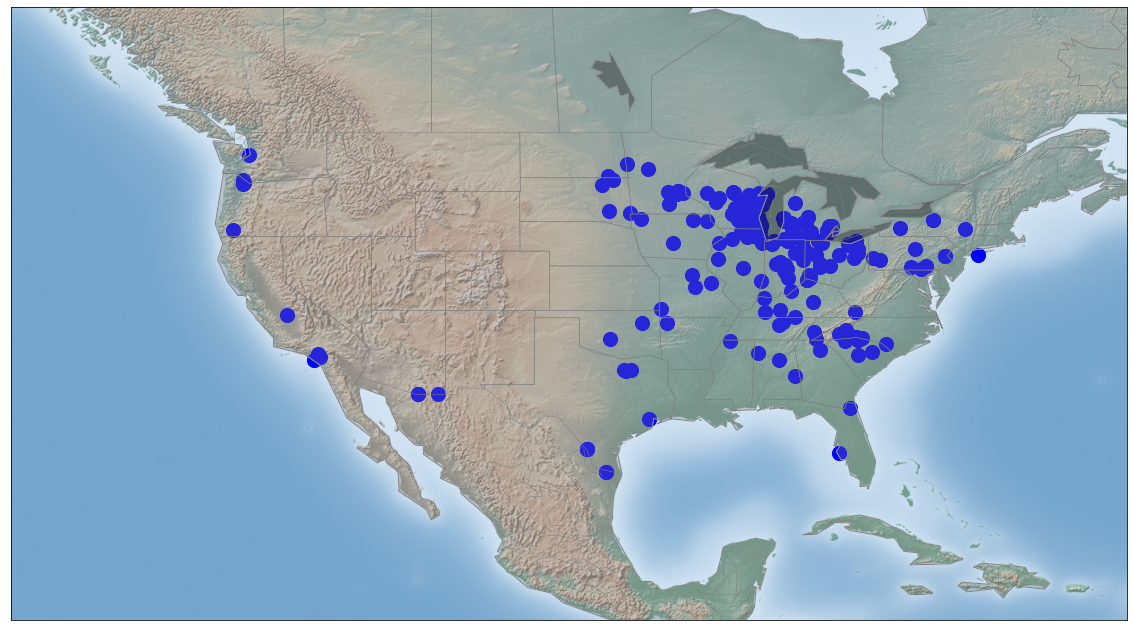

In [17]:
plt.figure(figsize=(20,20))
mm = Basemap(llcrnrlon = min(X[:,0])-15,llcrnrlat = min(X[:,1]-10), urcrnrlon = max(X[:,0]+10),urcrnrlat = max(X[:,1]+10))
# mm.drawmapboundary(fill_color = '#A6CAE0',linewidth = 0)
mm.fillcontinents(color = 'grey', alpha = 0.3, lake_color = 'black')
mm.drawcoastlines(linewidth = 0.5,color = 'white')

mm.shadedrelief()
mm.drawcoastlines(color='gray')
mm.drawcountries(color='gray')
mm.drawstates(color='gray')


plt.scatter(X[:,0],X[:,1],s=200,cmap='viridis',c='blue')
plt.show()

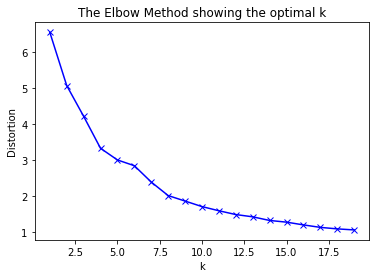

In [18]:
distortions = []
K = range(1,20)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(geo)
    distortions.append(sum(np.min(cdist(geo,kmeans.cluster_centers_,'euclidean'),axis=1))/geo.shape[0])

df_distortion = pd.DataFrame(distortions,columns=['sum_square_distances_to_center'])
df_distortion.to_csv(r'C:\Users\u279014\Documents\H_Drive\7.AA Models\12.Logistic_Optimization\data\k_selection.csv',index='No_cluster')  

    # Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [19]:
df_distortion['distortion_moving_diff'] = df_distortion.sum_square_distances_to_center.diff(-1)

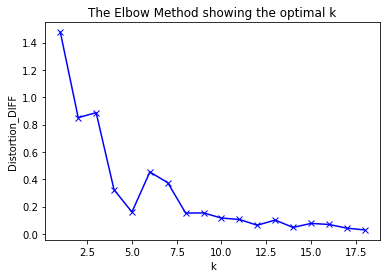

In [20]:
plt.plot(K, df_distortion.distortion_moving_diff, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion_DIFF')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [21]:
df_distortion.to_csv(r'C:\Users\u279014\Documents\H_Drive\7.AA Models\12.Logistic_Optimization\data\k_selection.csv',index='No_cluster')  

In [22]:
id_n=8
kmeans = KMeans(n_clusters=id_n, random_state=0).fit(geo)
id_label=kmeans.labels_
kmeans_centers = kmeans.cluster_centers_

In [23]:
geo_cass = cass_zip
geo_cass['label'] = kmeans.labels_
geo_cass.to_csv(r'C:\Users\u279014\Documents\H_Drive\7.AA Models\12.Logistic_Optimization\data\geo_cass.csv',index=False)  

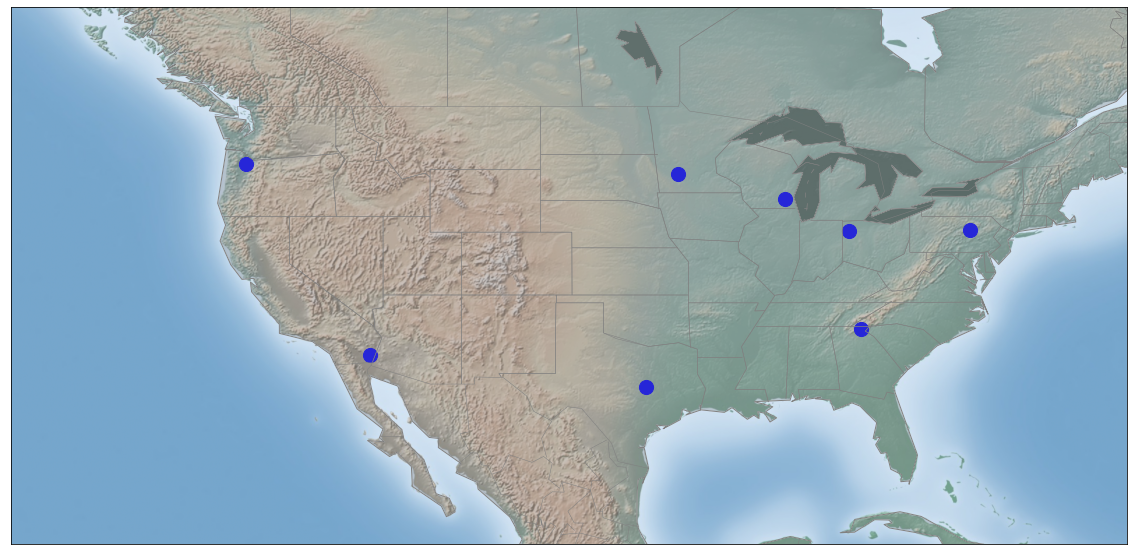

In [24]:
plt.figure(figsize=(20,20))
mm = Basemap(llcrnrlon = min(kmeans_centers[:,0])-15,llcrnrlat = min(kmeans_centers[:,1]-10), 
             urcrnrlon = max(kmeans_centers[:,0]+10),urcrnrlat = max(kmeans_centers[:,1]+10))
mm.fillcontinents(color = 'grey', alpha = 0.3, lake_color = 'black')
mm.drawcoastlines(linewidth = 0.5,color = 'white')

mm.shadedrelief()
mm.drawcoastlines(color='gray')
mm.drawcountries(color='gray')
mm.drawstates(color='gray')

plt.scatter(kmeans_centers[:,0],kmeans_centers[:,1],s=200,cmap='viridis',c='blue')
plt.show()

### Solution 2: DBSCAN_Modeling:
####  - advantange: calculates gap distance limitation & precomputed distance matrix gives more flexibilit
#### -  weakness: not mentioning where to be center

In [25]:
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform

In [26]:
s = 'WI,IL'

In [27]:
if not isinstance(s, list):
    new_s = s.split(',')

In [28]:
new_s

['WI', 'IL']

In [29]:
cluster_selections = ['WI','IL','MI','IN','IA','MI']
geo = cass_zip[cass_zip.shipper_state.isin(cluster_selections)].reset_index()

In [44]:
type(geo.zip_code[0])

str

In [31]:
# distance_matrix = distance_on_sphere_numpy(geo)

### Distance_Matrix using actual riding distance >>>>

In [32]:
path = r'C:\Users\u279014\Documents\H_Drive\7.AA Models\12.Logistic_Optimization\data'
file = r'riding_distance_matrix.xlsx'
riding_distance_matrix = load_riding_distance_matrix(path,file)
distance_matrix = riding_distance(riding_distance_matrix, geo)

In [42]:
np.any(riding_distance_matrix.columns == '53012')

True

In [28]:
"""
parameter:
    eps: location to core distance in between
    min_samples: minimum locations in one group(cluster)
    metric: precomputed as we have our own distance metricx
return:
    cluster model
"""
db = DBSCAN(eps=20,min_samples=3,metric='precomputed',leaf_size=30)
db.fit(distance_matrix)

DBSCAN(eps=20, metric='precomputed', min_samples=3)

In [29]:
# Save csv for PowerBI visualization
geo['label']=db.labels_
geo.to_csv('cass_zip_cluster.csv',index=False)
geo.to_feather('cass_zip_cluster')

C:\ProgramData\Anaconda3\lib\site-packages\pyarrow\feather.py:85: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(df, _pandas_api.pd.SparseDataFrame):


In [30]:
# let's take a look which cluster has most locations:
counter = Counter(db.labels_)
counter.most_common()

[(-1, 52),
 (6, 30),
 (12, 9),
 (8, 7),
 (0, 6),
 (10, 6),
 (1, 5),
 (2, 5),
 (5, 5),
 (3, 4),
 (4, 3),
 (7, 3),
 (9, 3),
 (11, 3)]

## Now, go to PowerBi for Reviewing >>>>>>>